# Setup

In [2]:
from collections import Counter
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import statsmodels.formula.api as smf
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU

In [71]:
def analyze_accuracy(y_test, y_pred_prob, y_pred_class):
    naive_pred = [1 for i in range(len(y_pred_class))]
    
    ns_auc = roc_auc_score(y_test, naive_pred)
    md_auc = roc_auc_score(y_test, y_pred_prob)
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model   : ROC AUC=%.3f' % (md_auc))
    
    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True)
    plt.show()
    
    ns_fpr, ns_tpr, _ = roc_curve(y_test, naive_pred)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_prob)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [74]:
def plot_calibration(y_test, y_prob):
    fop, mpv = calibration_curve(y_test,y_prob, n_bins=10, normalize=True)
    # plot perfectly calibrated
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    plt.plot(mpv, fop, marker='.')
    plt.show()

In [34]:
def setup_chess_data():
    df = pd.read_csv("chess_king_rook_dataset.csv")
    
    df['win'] = df['result'] != 'draw'
    df['win'] = df['win'].astype(int)
    
    for col in df.columns:
        if "rank" in col:
            df[col] = df[col].astype(str)

    dummy_df = copy.deepcopy(df)
    del dummy_df['result']
    
    dummy_df = pd.get_dummies(dummy_df)
    for col in dummy_df.columns:
        dummy_df[col] = dummy_df[col].astype(float)
    dummy_df['result'] = df['result']
    
    col_list = []
    for col in dummy_df.columns:
        if col != 'win' and col != 'result':
            col_list.append(col)

    X = dummy_df.loc[:, col_list]
    y = dummy_df['win']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    return X_train, X_test, y_train, y_test

In [35]:
X_train, X_test, y_train, y_test = setup_chess_data()

# First NN Model

In [63]:
model = Sequential()
model.add(Dropout(0.2))
model.add(Dense(12, input_dim=40, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [64]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [65]:
model.fit(X_train.values, y_train.values, epochs=100, batch_size=10)

Train on 22444 samples
Epoch 1/100
22444/22444 [==============================] - 4s 168us/sample - loss: 0.3281 - accuracy: 0.8994
Epoch 2/100
22444/22444 [==============================] - 3s 130us/sample - loss: 0.3004 - accuracy: 0.9003
Epoch 3/100
22444/22444 [==============================] - 3s 133us/sample - loss: 0.2731 - accuracy: 0.9005
Epoch 4/100
22444/22444 [==============================] - 3s 153us/sample - loss: 0.2536 - accuracy: 0.9012
Epoch 5/100
22444/22444 [==============================] - 3s 145us/sample - loss: 0.2369 - accuracy: 0.9020
Epoch 6/100
22444/22444 [==============================] - 5s 205us/sample - loss: 0.2300 - accuracy: 0.9044
Epoch 7/100
22444/22444 [==============================] - 3s 139us/sample - loss: 0.2241 - accuracy: 0.9075
Epoch 8/100
22444/22444 [==============================] - 3s 125us/sample - loss: 0.2223 - accuracy: 0.9087
Epoch 9/100
22444/22444 [==============================] - 3s 129us/sample - loss: 0.2169 - accuracy: 0.9

22444/22444 [==============================] - 3s 121us/sample - loss: 0.1779 - accuracy: 0.9254
Epoch 76/100
22444/22444 [==============================] - 3s 128us/sample - loss: 0.1852 - accuracy: 0.9227
Epoch 77/100
22444/22444 [==============================] - 3s 123us/sample - loss: 0.1838 - accuracy: 0.9238
Epoch 78/100
22444/22444 [==============================] - 3s 140us/sample - loss: 0.1816 - accuracy: 0.9225
Epoch 79/100
22444/22444 [==============================] - 3s 123us/sample - loss: 0.1830 - accuracy: 0.9225
Epoch 80/100
22444/22444 [==============================] - 3s 120us/sample - loss: 0.1829 - accuracy: 0.9228
Epoch 81/100
22444/22444 [==============================] - 3s 123us/sample - loss: 0.1850 - accuracy: 0.9198
Epoch 82/100
22444/22444 [==============================] - 3s 122us/sample - loss: 0.1820 - accuracy: 0.9230
Epoch 83/100
22444/22444 [==============================] - 3s 123us/sample - loss: 0.1831 - accuracy: 0.9234
Epoch 84/100
22444/2244

In [70]:
y_pred_prob = model.predict(X_test.values)
y_pred_class = [int(x >= 0.5) for x in y_pred_prob]

## Accuracy and Calibration

No Skill: ROC AUC=0.500
Model   : ROC AUC=0.980


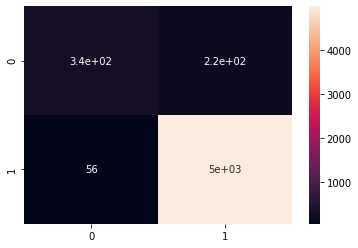

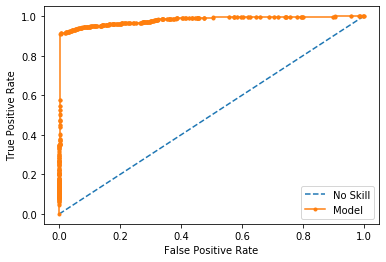

In [72]:
analyze_accuracy(y_test, y_pred_prob, y_pred_class)

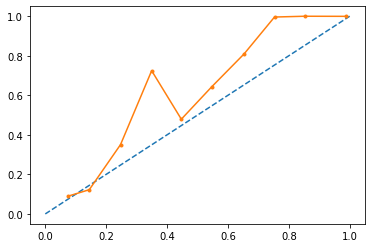

In [76]:
plot_calibration(y_test, y_pred_prob)

## Second Model: Leakly Relu

In [79]:
lrelu = lambda x: tensorflow.keras.activations.relu(x, alpha=0.1)

lr_model = Sequential()
lr_model.add(Dropout(0.2))
lr_model.add(Dense(12, input_dim=40, activation=lrelu))
lr_model.add(Dropout(0.2))
lr_model.add(Dense(8, activation=lrelu))
lr_model.add(Dense(1, activation='sigmoid'))

In [81]:
lr_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [83]:
lr_model.fit(X_train.values, y_train.values, epochs=100, batch_size=10)

Train on 22444 samples
Epoch 1/100
22444/22444 [==============================] - 6s 258us/sample - loss: 0.1798 - accuracy: 0.9225
Epoch 2/100
22444/22444 [==============================] - 6s 265us/sample - loss: 0.1769 - accuracy: 0.9233
Epoch 3/100
22444/22444 [==============================] - 6s 282us/sample - loss: 0.1796 - accuracy: 0.9224
Epoch 4/100
22444/22444 [==============================] - 7s 309us/sample - loss: 0.1798 - accuracy: 0.9228
Epoch 5/100
22444/22444 [==============================] - 6s 266us/sample - loss: 0.1780 - accuracy: 0.9243
Epoch 6/100
22444/22444 [==============================] - 6s 270us/sample - loss: 0.1761 - accuracy: 0.9251
Epoch 7/100
22444/22444 [==============================] - 7s 295us/sample - loss: 0.1797 - accuracy: 0.9239
Epoch 8/100
22444/22444 [==============================] - 6s 273us/sample - loss: 0.1798 - accuracy: 0.9228
Epoch 9/100
22444/22444 [==============================] - 6s 270us/sample - loss: 0.1772 - accuracy: 0.9

22444/22444 [==============================] - 6s 264us/sample - loss: 0.1721 - accuracy: 0.9260
Epoch 76/100
22444/22444 [==============================] - 6s 262us/sample - loss: 0.1735 - accuracy: 0.9254
Epoch 77/100
22444/22444 [==============================] - 6s 265us/sample - loss: 0.1738 - accuracy: 0.9253
Epoch 78/100
22444/22444 [==============================] - 7s 293us/sample - loss: 0.1724 - accuracy: 0.9272
Epoch 79/100
22444/22444 [==============================] - 6s 287us/sample - loss: 0.1713 - accuracy: 0.9283
Epoch 80/100
22444/22444 [==============================] - 7s 312us/sample - loss: 0.1745 - accuracy: 0.9254
Epoch 81/100
22444/22444 [==============================] - 7s 311us/sample - loss: 0.1756 - accuracy: 0.9259
Epoch 82/100
22444/22444 [==============================] - 7s 308us/sample - loss: 0.1728 - accuracy: 0.9268
Epoch 83/100
22444/22444 [==============================] - 6s 283us/sample - loss: 0.1731 - accuracy: 0.9276
Epoch 84/100
22444/2244

Leaky relu seems to start at a higher level of accuracy, but gains less over time

In [89]:
y_pred_prob_lr = lr_model.predict(X_test.values)
y_pred_class_lr = [int(x >= 0.5) for x in y_pred_prob_lr]

No Skill: ROC AUC=0.500
Model   : ROC AUC=0.974


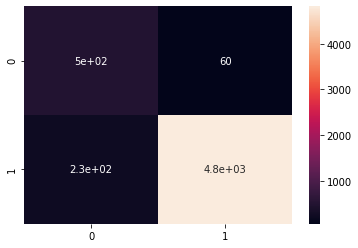

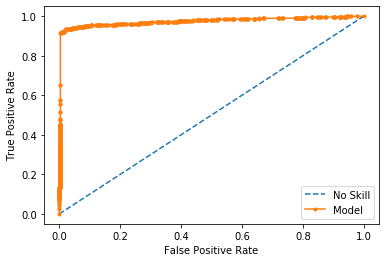

In [90]:
analyze_accuracy(y_test, y_pred_prob_lr, y_pred_class_lr)

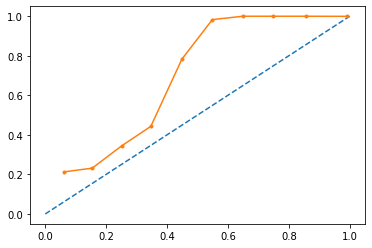

In [91]:
plot_calibration(y_test, y_pred_prob_lr)

In [ ]:
Overall, performs worse than regular relu. But, again, this is without any paramater tuning